In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# -----------------------------
# 1. Data Preprocessing
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_B"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f"{data_dir}/train/Fielding", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Fielding", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Fielding", transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

classes = train_ds.classes
print("Classes:", classes)

Classes: ['boundary_save', 'catching_a_ball', 'diving_stop', 'run_out', 'stumping']


In [2]:
print("Total training images:", len(train_ds))
print("Total validation images:", len(val_ds))
print("Total test images:", len(test_ds))

total_images = len(train_ds) + len(val_ds) + len(test_ds)
print("Total images in dataset:", total_images)

Total training images: 1917
Total validation images: 504
Total test images: 630
Total images in dataset: 3051


In [3]:
ignore_folder = "random_occlusion"

def count_images_ignore_folder(dataset, ignore_folder):
    count = 0
    for img_path, label in dataset.samples:
        # Skip if the image path contains the ignore_folder
        if ignore_folder not in img_path.split("/"):
            count += 1
    return count

train_count = count_images_ignore_folder(train_ds, ignore_folder)
val_count   = count_images_ignore_folder(val_ds, ignore_folder)
test_count  = count_images_ignore_folder(test_ds, ignore_folder)

total_count = train_count + val_count + test_count

print("Training images (excluding '{}'): {}".format(ignore_folder, train_count))
print("Validation images (excluding '{}'): {}".format(ignore_folder, val_count))
print("Test images (excluding '{}'): {}".format(ignore_folder, test_count))
print("Total images (excluding '{}'): {}".format(ignore_folder, total_count))

Training images (excluding 'random_occlusion'): 1704
Validation images (excluding 'random_occlusion'): 448
Test images (excluding 'random_occlusion'): 560
Total images (excluding 'random_occlusion'): 2712


In [4]:
ignore_folder = "random_occlusionw"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'original', 'lens_flare', 'dirty_lens', 'blur', 'chromatic_aberration', 'motion_blur', 'random_occlusion', 'gaussian_noise', 'low_resolution'}
Validation folders considered: {'original', 'lens_flare', 'dirty_lens', 'blur', 'chromatic_aberration', 'motion_blur', 'random_occlusion', 'gaussian_noise', 'low_resolution'}
Test folders considered: {'original', 'lens_flare', 'dirty_lens', 'blur', 'chromatic_aberration', 'motion_blur', 'random_occlusion', 'gaussian_noise', 'low_resolution'}


In [5]:
ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    # Keep only samples where ignore_folder is NOT in the path
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]  # Update targets accordingly
    return dataset

# Create original datasets
train_ds = datasets.ImageFolder(f"{data_dir}/train/Fielding", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Fielding", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Fielding", transform=transform)

# Filter out 'random_occlusion' folder
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Classes (will remain the same)
classes = train_ds.classes
print("Classes:", classes)

# Show counts
print("Final Training images:", len(train_ds))
print("Final Validation images:", len(val_ds))
print("Final Test images:", len(test_ds))
print("Total images after filtering:", len(train_ds) + len(val_ds) + len(test_ds))

Classes: ['boundary_save', 'catching_a_ball', 'diving_stop', 'run_out', 'stumping']
Final Training images: 1704
Final Validation images: 448
Final Test images: 560
Total images after filtering: 2712


In [6]:
ignore_folder = "random_occlusion"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'original', 'lens_flare', 'dirty_lens', 'blur', 'chromatic_aberration', 'motion_blur', 'gaussian_noise', 'low_resolution'}
Validation folders considered: {'original', 'lens_flare', 'dirty_lens', 'blur', 'chromatic_aberration', 'motion_blur', 'gaussian_noise', 'low_resolution'}
Test folders considered: {'original', 'lens_flare', 'dirty_lens', 'blur', 'chromatic_aberration', 'motion_blur', 'gaussian_noise', 'low_resolution'}


In [7]:
# -----------------------------
# 2. Define DenseNet-121 Model from Scratch
# -----------------------------

class DenseLayer(nn.Module):
    """Single Dense Layer: BN-ReLU-Conv(1x1)-BN-ReLU-Conv(3x3)"""
    def __init__(self, in_channels, growth_rate=32, bn_size=4):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, bn_size * growth_rate, 
                              kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate, 
                              kernel_size=3, padding=1, bias=False)
        
    def forward(self, x):
        # First convolution block
        out = F.relu(self.bn1(x))
        out = self.conv1(out)
        
        # Second convolution block
        out = F.relu(self.bn2(out))
        out = self.conv2(out)
        
        # Concatenate input with output (dense connection)
        return torch.cat([x, out], 1)

class DenseBlock(nn.Module):
    """Dense Block containing multiple Dense Layers"""
    def __init__(self, num_layers, in_channels, growth_rate=32, bn_size=4):
        super().__init__()
        self.layers = nn.ModuleList()
        
        for i in range(num_layers):
            layer = DenseLayer(in_channels + i * growth_rate, growth_rate, bn_size)
            self.layers.append(layer)
            
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class TransitionLayer(nn.Module):
    """Transition Layer: BN-ReLU-Conv(1x1)-AvgPool(2x2)"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        out = F.relu(self.bn(x))
        out = self.conv(out)
        out = self.pool(out)
        return out

class MyDenseNet121(nn.Module):
    """DenseNet-121 Implementation from Scratch"""
    def __init__(self, in_channels=3, classes=4, growth_rate=32, 
                 block_config=[6, 12, 24, 16], bn_size=4, compression_rate=0.5):
        super().__init__()
        
        # Initial convolution layer
        self.initial_conv = nn.Conv2d(in_channels, 64, kernel_size=7, 
                                     stride=2, padding=3, bias=False)
        self.initial_bn = nn.BatchNorm2d(64)
        self.initial_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Dense blocks and transition layers
        num_features = 64
        
        # Dense Block 1 + Transition 1
        self.dense_block1 = DenseBlock(block_config[0], num_features, growth_rate, bn_size)
        num_features += block_config[0] * growth_rate
        out_features = int(num_features * compression_rate)
        self.transition1 = TransitionLayer(num_features, out_features)
        num_features = out_features
        
        # Dense Block 2 + Transition 2
        self.dense_block2 = DenseBlock(block_config[1], num_features, growth_rate, bn_size)
        num_features += block_config[1] * growth_rate
        out_features = int(num_features * compression_rate)
        self.transition2 = TransitionLayer(num_features, out_features)
        num_features = out_features
        
        # Dense Block 3 + Transition 3
        self.dense_block3 = DenseBlock(block_config[2], num_features, growth_rate, bn_size)
        num_features += block_config[2] * growth_rate
        out_features = int(num_features * compression_rate)
        self.transition3 = TransitionLayer(num_features, out_features)
        num_features = out_features
        
        # Dense Block 4 (no transition after last block)
        self.dense_block4 = DenseBlock(block_config[3], num_features, growth_rate, bn_size)
        num_features += block_config[3] * growth_rate
        
        # Final layers
        self.final_bn = nn.BatchNorm2d(num_features)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.classifier = nn.Linear(num_features, classes)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights using He initialization for conv layers"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Initial convolution and pooling
        x = self.initial_conv(x)
        x = F.relu(self.initial_bn(x))
        x = self.initial_pool(x)
        
        # Dense blocks with transitions
        x = self.dense_block1(x)
        x = self.transition1(x)
        
        x = self.dense_block2(x)
        x = self.transition2(x)
        
        x = self.dense_block3(x)
        x = self.transition3(x)
        
        x = self.dense_block4(x)
        
        # Final classification layers
        x = F.relu(self.final_bn(x))
        x = self.global_pool(x)
        x = self.flatten(x)
        x = self.classifier(x)
        
        return x

# -----------------------------
# 3. Training Setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyDenseNet121(3, classes=len(classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("DenseNet-121 Model Summary:")
summary(model, (3, 224, 224))

DenseNet-121 Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
         MaxPool2d-3           [-1, 64, 56, 56]               0
       BatchNorm2d-4           [-1, 64, 56, 56]             128
            Conv2d-5          [-1, 128, 56, 56]           8,192
       BatchNorm2d-6          [-1, 128, 56, 56]             256
            Conv2d-7           [-1, 32, 56, 56]          36,864
        DenseLayer-8           [-1, 96, 56, 56]               0
       BatchNorm2d-9           [-1, 96, 56, 56]             192
           Conv2d-10          [-1, 128, 56, 56]          12,288
      BatchNorm2d-11          [-1, 128, 56, 56]             256
           Conv2d-12           [-1, 32, 56, 56]          36,864
       DenseLayer-13          [-1, 128, 56, 56]               0
      Batch


🚀 Starting DenseNet-121 Training for 50 epochs...

📈 Epoch 1/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:44<00:00,  1.20it/s, Loss=1.3695, Acc=0.4149]


✅ Training completed in 44.88s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:07<00:00,  1.85it/s, Loss=1.5892, Acc=0.3147]


✅ Validation completed in 7.58s
🌟 New best DenseNet-121 model found! Validation Accuracy: 0.3147

📊 Epoch 1 Summary:
│ Train Loss: 1.3695 | Train Acc: 0.4149
│ Val Loss:   1.5892 | Val Acc:   0.3147
│ Train Time: 44.88s | Val Time: 7.58s
│ Total Epoch Time: 52.46s
│ Best Val Acc: 0.3147 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 2/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:31<00:00,  1.69it/s, Loss=1.0625, Acc=0.5816]


✅ Training completed in 31.92s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.09it/s, Loss=1.7013, Acc=0.4107]


✅ Validation completed in 4.54s
🌟 New best DenseNet-121 model found! Validation Accuracy: 0.4107

📊 Epoch 2 Summary:
│ Train Loss: 1.0625 | Train Acc: 0.5816
│ Val Loss:   1.7013 | Val Acc:   0.4107
│ Train Time: 31.92s | Val Time: 4.54s
│ Total Epoch Time: 36.47s
│ Best Val Acc: 0.4107 (Epoch 2)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 3/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:33<00:00,  1.59it/s, Loss=0.9093, Acc=0.6549]


✅ Training completed in 34.00s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.00it/s, Loss=1.6817, Acc=0.4129]


✅ Validation completed in 4.67s
🌟 New best DenseNet-121 model found! Validation Accuracy: 0.4129

📊 Epoch 3 Summary:
│ Train Loss: 0.9093 | Train Acc: 0.6549
│ Val Loss:   1.6817 | Val Acc:   0.4129
│ Train Time: 34.00s | Val Time: 4.67s
│ Total Epoch Time: 38.67s
│ Best Val Acc: 0.4129 (Epoch 3)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 4/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:32<00:00,  1.65it/s, Loss=0.6827, Acc=0.7482]


✅ Training completed in 32.81s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.17it/s, Loss=1.6922, Acc=0.5089]


✅ Validation completed in 4.42s
🌟 New best DenseNet-121 model found! Validation Accuracy: 0.5089

📊 Epoch 4 Summary:
│ Train Loss: 0.6827 | Train Acc: 0.7482
│ Val Loss:   1.6922 | Val Acc:   0.5089
│ Train Time: 32.81s | Val Time: 4.42s
│ Total Epoch Time: 37.24s
│ Best Val Acc: 0.5089 (Epoch 4)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 5/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:33<00:00,  1.63it/s, Loss=0.5007, Acc=0.8175]


✅ Training completed in 33.06s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.08it/s, Loss=1.9824, Acc=0.4665]


✅ Validation completed in 4.55s

📊 Epoch 5 Summary:
│ Train Loss: 0.5007 | Train Acc: 0.8175
│ Val Loss:   1.9824 | Val Acc:   0.4665
│ Train Time: 33.06s | Val Time: 4.55s
│ Total Epoch Time: 37.61s
│ Best Val Acc: 0.5089 (Epoch 4)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 6/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:32<00:00,  1.64it/s, Loss=0.3528, Acc=0.8674]


✅ Training completed in 32.98s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.13it/s, Loss=2.2590, Acc=0.4353]


✅ Validation completed in 4.47s

📊 Epoch 6 Summary:
│ Train Loss: 0.3528 | Train Acc: 0.8674
│ Val Loss:   2.2590 | Val Acc:   0.4353
│ Train Time: 32.98s | Val Time: 4.47s
│ Total Epoch Time: 37.45s
│ Best Val Acc: 0.5089 (Epoch 4)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 7/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:33<00:00,  1.63it/s, Loss=0.3026, Acc=0.8950]


✅ Training completed in 33.10s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  2.99it/s, Loss=2.1942, Acc=0.4888]


✅ Validation completed in 4.69s

📊 Epoch 7 Summary:
│ Train Loss: 0.3026 | Train Acc: 0.8950
│ Val Loss:   2.1942 | Val Acc:   0.4888
│ Train Time: 33.10s | Val Time: 4.69s
│ Total Epoch Time: 37.80s
│ Best Val Acc: 0.5089 (Epoch 4)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 8/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:32<00:00,  1.64it/s, Loss=0.3134, Acc=0.8914]


✅ Training completed in 32.90s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.07it/s, Loss=1.9233, Acc=0.4844]


✅ Validation completed in 4.57s

📊 Epoch 8 Summary:
│ Train Loss: 0.3134 | Train Acc: 0.8914
│ Val Loss:   1.9233 | Val Acc:   0.4844
│ Train Time: 32.90s | Val Time: 4.57s
│ Total Epoch Time: 37.47s
│ Best Val Acc: 0.5089 (Epoch 4)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 9/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:33<00:00,  1.63it/s, Loss=0.2437, Acc=0.9208]


✅ Training completed in 33.09s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.00it/s, Loss=1.9374, Acc=0.5134]


✅ Validation completed in 4.67s
🌟 New best DenseNet-121 model found! Validation Accuracy: 0.5134

📊 Epoch 9 Summary:
│ Train Loss: 0.2437 | Train Acc: 0.9208
│ Val Loss:   1.9374 | Val Acc:   0.5134
│ Train Time: 33.09s | Val Time: 4.67s
│ Total Epoch Time: 37.78s
│ Best Val Acc: 0.5134 (Epoch 9)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 10/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:33<00:00,  1.63it/s, Loss=0.2338, Acc=0.9184]


✅ Training completed in 33.06s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.11it/s, Loss=2.5437, Acc=0.5246]


✅ Validation completed in 4.50s
🌟 New best DenseNet-121 model found! Validation Accuracy: 0.5246

📊 Epoch 10 Summary:
│ Train Loss: 0.2338 | Train Acc: 0.9184
│ Val Loss:   2.5437 | Val Acc:   0.5246
│ Train Time: 33.06s | Val Time: 4.50s
│ Total Epoch Time: 37.57s
│ Best Val Acc: 0.5246 (Epoch 10)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 11/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:33<00:00,  1.62it/s, Loss=0.1546, Acc=0.9448]


✅ Training completed in 33.31s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  2.94it/s, Loss=2.0257, Acc=0.5268]


✅ Validation completed in 4.77s
🌟 New best DenseNet-121 model found! Validation Accuracy: 0.5268

📊 Epoch 11 Summary:
│ Train Loss: 0.1546 | Train Acc: 0.9448
│ Val Loss:   2.0257 | Val Acc:   0.5268
│ Train Time: 33.31s | Val Time: 4.77s
│ Total Epoch Time: 38.08s
│ Best Val Acc: 0.5268 (Epoch 11)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 12/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:33<00:00,  1.62it/s, Loss=0.0639, Acc=0.9812]


✅ Training completed in 33.32s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.03it/s, Loss=2.5003, Acc=0.5357]


✅ Validation completed in 4.63s
🌟 New best DenseNet-121 model found! Validation Accuracy: 0.5357

📊 Epoch 12 Summary:
│ Train Loss: 0.0639 | Train Acc: 0.9812
│ Val Loss:   2.5003 | Val Acc:   0.5357
│ Train Time: 33.32s | Val Time: 4.63s
│ Total Epoch Time: 37.96s
│ Best Val Acc: 0.5357 (Epoch 12)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 13/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:33<00:00,  1.63it/s, Loss=0.0967, Acc=0.9648]


✅ Training completed in 33.19s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.06it/s, Loss=2.4511, Acc=0.5223]


✅ Validation completed in 4.58s

📊 Epoch 13 Summary:
│ Train Loss: 0.0967 | Train Acc: 0.9648
│ Val Loss:   2.4511 | Val Acc:   0.5223
│ Train Time: 33.19s | Val Time: 4.58s
│ Total Epoch Time: 37.78s
│ Best Val Acc: 0.5357 (Epoch 12)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 14/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:33<00:00,  1.62it/s, Loss=0.1313, Acc=0.9560]


✅ Training completed in 33.35s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.05it/s, Loss=2.5474, Acc=0.5290]


✅ Validation completed in 4.59s

📊 Epoch 14 Summary:
│ Train Loss: 0.1313 | Train Acc: 0.9560
│ Val Loss:   2.5474 | Val Acc:   0.5290
│ Train Time: 33.35s | Val Time: 4.59s
│ Total Epoch Time: 37.95s
│ Best Val Acc: 0.5357 (Epoch 12)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 15/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:33<00:00,  1.63it/s, Loss=0.1304, Acc=0.9589]


✅ Training completed in 33.20s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.08it/s, Loss=2.9714, Acc=0.4978]


✅ Validation completed in 4.55s

📊 Epoch 15 Summary:
│ Train Loss: 0.1304 | Train Acc: 0.9589
│ Val Loss:   2.9714 | Val Acc:   0.4978
│ Train Time: 33.20s | Val Time: 4.55s
│ Total Epoch Time: 37.75s
│ Best Val Acc: 0.5357 (Epoch 12)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 16/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:32<00:00,  1.65it/s, Loss=0.0797, Acc=0.9695]


✅ Training completed in 32.82s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.15it/s, Loss=2.4012, Acc=0.5379]


✅ Validation completed in 4.45s
🌟 New best DenseNet-121 model found! Validation Accuracy: 0.5379

📊 Epoch 16 Summary:
│ Train Loss: 0.0797 | Train Acc: 0.9695
│ Val Loss:   2.4012 | Val Acc:   0.5379
│ Train Time: 32.82s | Val Time: 4.45s
│ Total Epoch Time: 37.28s
│ Best Val Acc: 0.5379 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 17/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:32<00:00,  1.65it/s, Loss=0.0350, Acc=0.9906]


✅ Training completed in 32.78s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.06it/s, Loss=2.9324, Acc=0.5000]


✅ Validation completed in 4.58s

📊 Epoch 17 Summary:
│ Train Loss: 0.0350 | Train Acc: 0.9906
│ Val Loss:   2.9324 | Val Acc:   0.5000
│ Train Time: 32.78s | Val Time: 4.58s
│ Total Epoch Time: 37.37s
│ Best Val Acc: 0.5379 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 18/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:33<00:00,  1.63it/s, Loss=0.0576, Acc=0.9830]


✅ Training completed in 33.04s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.07it/s, Loss=2.9365, Acc=0.4464]


✅ Validation completed in 4.56s

📊 Epoch 18 Summary:
│ Train Loss: 0.0576 | Train Acc: 0.9830
│ Val Loss:   2.9365 | Val Acc:   0.4464
│ Train Time: 33.04s | Val Time: 4.56s
│ Total Epoch Time: 37.60s
│ Best Val Acc: 0.5379 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 19/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:32<00:00,  1.64it/s, Loss=0.0860, Acc=0.9707]


✅ Training completed in 32.94s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.07it/s, Loss=2.5751, Acc=0.5491]


✅ Validation completed in 4.56s
🌟 New best DenseNet-121 model found! Validation Accuracy: 0.5491

📊 Epoch 19 Summary:
│ Train Loss: 0.0860 | Train Acc: 0.9707
│ Val Loss:   2.5751 | Val Acc:   0.5491
│ Train Time: 32.94s | Val Time: 4.56s
│ Total Epoch Time: 37.51s
│ Best Val Acc: 0.5491 (Epoch 19)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 20/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:33<00:00,  1.64it/s, Loss=0.0407, Acc=0.9853]


✅ Training completed in 33.01s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.12it/s, Loss=2.7905, Acc=0.5223]


✅ Validation completed in 4.48s

📊 Epoch 20 Summary:
│ Train Loss: 0.0407 | Train Acc: 0.9853
│ Val Loss:   2.7905 | Val Acc:   0.5223
│ Train Time: 33.01s | Val Time: 4.48s
│ Total Epoch Time: 37.50s
│ Best Val Acc: 0.5491 (Epoch 19)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 21/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:33<00:00,  1.63it/s, Loss=0.0397, Acc=0.9894]


✅ Training completed in 33.05s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.08it/s, Loss=2.8853, Acc=0.5000]


✅ Validation completed in 4.54s

📊 Epoch 21 Summary:
│ Train Loss: 0.0397 | Train Acc: 0.9894
│ Val Loss:   2.8853 | Val Acc:   0.5000
│ Train Time: 33.05s | Val Time: 4.54s
│ Total Epoch Time: 37.60s
│ Best Val Acc: 0.5491 (Epoch 19)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 22/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:32<00:00,  1.64it/s, Loss=0.0633, Acc=0.9777]


✅ Training completed in 33.00s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.10it/s, Loss=2.4772, Acc=0.5179]


✅ Validation completed in 4.52s

📊 Epoch 22 Summary:
│ Train Loss: 0.0633 | Train Acc: 0.9777
│ Val Loss:   2.4772 | Val Acc:   0.5179
│ Train Time: 33.00s | Val Time: 4.52s
│ Total Epoch Time: 37.52s
│ Best Val Acc: 0.5491 (Epoch 19)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 23/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:32<00:00,  1.65it/s, Loss=0.1398, Acc=0.9531]


✅ Training completed in 32.81s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.15it/s, Loss=3.4068, Acc=0.5112]


✅ Validation completed in 4.45s

📊 Epoch 23 Summary:
│ Train Loss: 0.1398 | Train Acc: 0.9531
│ Val Loss:   3.4068 | Val Acc:   0.5112
│ Train Time: 32.81s | Val Time: 4.45s
│ Total Epoch Time: 37.27s
│ Best Val Acc: 0.5491 (Epoch 19)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 24/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:32<00:00,  1.65it/s, Loss=0.0710, Acc=0.9759]


✅ Training completed in 32.80s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.19it/s, Loss=2.7359, Acc=0.4911]


✅ Validation completed in 4.40s

📊 Epoch 24 Summary:
│ Train Loss: 0.0710 | Train Acc: 0.9759
│ Val Loss:   2.7359 | Val Acc:   0.4911
│ Train Time: 32.80s | Val Time: 4.40s
│ Total Epoch Time: 37.20s
│ Best Val Acc: 0.5491 (Epoch 19)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 25/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:32<00:00,  1.65it/s, Loss=0.0300, Acc=0.9900]


✅ Training completed in 32.72s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.09it/s, Loss=2.6525, Acc=0.5134]


✅ Validation completed in 4.53s

📊 Epoch 25 Summary:
│ Train Loss: 0.0300 | Train Acc: 0.9900
│ Val Loss:   2.6525 | Val Acc:   0.5134
│ Train Time: 32.72s | Val Time: 4.53s
│ Total Epoch Time: 37.25s
│ Best Val Acc: 0.5491 (Epoch 19)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 26/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:32<00:00,  1.65it/s, Loss=0.1061, Acc=0.9754]


✅ Training completed in 32.73s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.17it/s, Loss=4.1135, Acc=0.4375]


✅ Validation completed in 4.42s

📊 Epoch 26 Summary:
│ Train Loss: 0.1061 | Train Acc: 0.9754
│ Val Loss:   4.1135 | Val Acc:   0.4375
│ Train Time: 32.73s | Val Time: 4.42s
│ Total Epoch Time: 37.16s
│ Best Val Acc: 0.5491 (Epoch 19)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 27/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:32<00:00,  1.65it/s, Loss=0.1043, Acc=0.9654]


✅ Training completed in 32.78s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.15it/s, Loss=2.9154, Acc=0.4866]


✅ Validation completed in 4.44s

📊 Epoch 27 Summary:
│ Train Loss: 0.1043 | Train Acc: 0.9654
│ Val Loss:   2.9154 | Val Acc:   0.4866
│ Train Time: 32.78s | Val Time: 4.44s
│ Total Epoch Time: 37.23s
│ Best Val Acc: 0.5491 (Epoch 19)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 28/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:32<00:00,  1.66it/s, Loss=0.0233, Acc=0.9941]


✅ Training completed in 32.52s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.17it/s, Loss=2.6565, Acc=0.4888]


✅ Validation completed in 4.42s

📊 Epoch 28 Summary:
│ Train Loss: 0.0233 | Train Acc: 0.9941
│ Val Loss:   2.6565 | Val Acc:   0.4888
│ Train Time: 32.52s | Val Time: 4.42s
│ Total Epoch Time: 36.95s
│ Best Val Acc: 0.5491 (Epoch 19)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 29/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:32<00:00,  1.65it/s, Loss=0.0256, Acc=0.9930]


✅ Training completed in 32.67s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.17it/s, Loss=3.1649, Acc=0.4196]


✅ Validation completed in 4.41s

📊 Epoch 29 Summary:
│ Train Loss: 0.0256 | Train Acc: 0.9930
│ Val Loss:   3.1649 | Val Acc:   0.4196
│ Train Time: 32.67s | Val Time: 4.41s
│ Total Epoch Time: 37.09s
│ Best Val Acc: 0.5491 (Epoch 19)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 30/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:32<00:00,  1.65it/s, Loss=0.0672, Acc=0.9824]


✅ Training completed in 32.67s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.21it/s, Loss=3.0709, Acc=0.4866]


✅ Validation completed in 4.36s

📊 Epoch 30 Summary:
│ Train Loss: 0.0672 | Train Acc: 0.9824
│ Val Loss:   3.0709 | Val Acc:   0.4866
│ Train Time: 32.67s | Val Time: 4.36s
│ Total Epoch Time: 37.04s
│ Best Val Acc: 0.5491 (Epoch 19)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 31/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:32<00:00,  1.65it/s, Loss=0.0495, Acc=0.9871]


✅ Training completed in 32.69s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.16it/s, Loss=3.1678, Acc=0.4219]


✅ Validation completed in 4.43s

📊 Epoch 31 Summary:
│ Train Loss: 0.0495 | Train Acc: 0.9871
│ Val Loss:   3.1678 | Val Acc:   0.4219
│ Train Time: 32.69s | Val Time: 4.43s
│ Total Epoch Time: 37.13s
│ Best Val Acc: 0.5491 (Epoch 19)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 32/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:32<00:00,  1.65it/s, Loss=0.0462, Acc=0.9847]


✅ Training completed in 32.67s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.19it/s, Loss=3.7851, Acc=0.4598]


✅ Validation completed in 4.39s

📊 Epoch 32 Summary:
│ Train Loss: 0.0462 | Train Acc: 0.9847
│ Val Loss:   3.7851 | Val Acc:   0.4598
│ Train Time: 32.67s | Val Time: 4.39s
│ Total Epoch Time: 37.07s
│ Best Val Acc: 0.5491 (Epoch 19)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 33/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:32<00:00,  1.66it/s, Loss=0.0594, Acc=0.9824]


✅ Training completed in 32.46s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.08it/s, Loss=3.2296, Acc=0.4509]


✅ Validation completed in 4.55s

📊 Epoch 33 Summary:
│ Train Loss: 0.0594 | Train Acc: 0.9824
│ Val Loss:   3.2296 | Val Acc:   0.4509
│ Train Time: 32.46s | Val Time: 4.55s
│ Total Epoch Time: 37.02s
│ Best Val Acc: 0.5491 (Epoch 19)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 34/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:32<00:00,  1.67it/s, Loss=0.0319, Acc=0.9912]


✅ Training completed in 32.34s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.12it/s, Loss=2.9210, Acc=0.4643]


✅ Validation completed in 4.49s

📊 Epoch 34 Summary:
│ Train Loss: 0.0319 | Train Acc: 0.9912
│ Val Loss:   2.9210 | Val Acc:   0.4643
│ Train Time: 32.34s | Val Time: 4.49s
│ Total Epoch Time: 36.83s
│ Best Val Acc: 0.5491 (Epoch 19)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 35/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:32<00:00,  1.67it/s, Loss=0.0105, Acc=0.9982]


✅ Training completed in 32.43s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.13it/s, Loss=3.1315, Acc=0.5045]


✅ Validation completed in 4.47s

📊 Epoch 35 Summary:
│ Train Loss: 0.0105 | Train Acc: 0.9982
│ Val Loss:   3.1315 | Val Acc:   0.5045
│ Train Time: 32.43s | Val Time: 4.47s
│ Total Epoch Time: 36.91s
│ Best Val Acc: 0.5491 (Epoch 19)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 36/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:32<00:00,  1.68it/s, Loss=0.0062, Acc=0.9988]


✅ Training completed in 32.15s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.17it/s, Loss=3.1320, Acc=0.4799]


✅ Validation completed in 4.42s

📊 Epoch 36 Summary:
│ Train Loss: 0.0062 | Train Acc: 0.9988
│ Val Loss:   3.1320 | Val Acc:   0.4799
│ Train Time: 32.15s | Val Time: 4.42s
│ Total Epoch Time: 36.58s
│ Best Val Acc: 0.5491 (Epoch 19)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 37/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:32<00:00,  1.66it/s, Loss=0.0099, Acc=0.9965]


✅ Training completed in 32.47s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.15it/s, Loss=3.2312, Acc=0.5000]


✅ Validation completed in 4.45s

📊 Epoch 37 Summary:
│ Train Loss: 0.0099 | Train Acc: 0.9965
│ Val Loss:   3.2312 | Val Acc:   0.5000
│ Train Time: 32.47s | Val Time: 4.45s
│ Total Epoch Time: 36.93s
│ Best Val Acc: 0.5491 (Epoch 19)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 38/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:32<00:00,  1.68it/s, Loss=0.0090, Acc=0.9977]


✅ Training completed in 32.21s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.18it/s, Loss=3.2117, Acc=0.5246]


✅ Validation completed in 4.41s

📊 Epoch 38 Summary:
│ Train Loss: 0.0090 | Train Acc: 0.9977
│ Val Loss:   3.2117 | Val Acc:   0.5246
│ Train Time: 32.21s | Val Time: 4.41s
│ Total Epoch Time: 36.63s
│ Best Val Acc: 0.5491 (Epoch 19)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 39/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:32<00:00,  1.66it/s, Loss=0.0197, Acc=0.9988]


✅ Training completed in 32.46s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.04it/s, Loss=3.2359, Acc=0.4688]


✅ Validation completed in 4.61s

📊 Epoch 39 Summary:
│ Train Loss: 0.0197 | Train Acc: 0.9988
│ Val Loss:   3.2359 | Val Acc:   0.4688
│ Train Time: 32.46s | Val Time: 4.61s
│ Total Epoch Time: 37.07s
│ Best Val Acc: 0.5491 (Epoch 19)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 40/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:32<00:00,  1.65it/s, Loss=0.0544, Acc=0.9865]


✅ Training completed in 32.75s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.17it/s, Loss=3.9226, Acc=0.4085]


✅ Validation completed in 4.41s

📊 Epoch 40 Summary:
│ Train Loss: 0.0544 | Train Acc: 0.9865
│ Val Loss:   3.9226 | Val Acc:   0.4085
│ Train Time: 32.75s | Val Time: 4.41s
│ Total Epoch Time: 37.17s
│ Best Val Acc: 0.5491 (Epoch 19)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 41/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:32<00:00,  1.66it/s, Loss=0.1627, Acc=0.9431]


✅ Training completed in 32.45s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.18it/s, Loss=3.0768, Acc=0.4955]


✅ Validation completed in 4.40s

📊 Epoch 41 Summary:
│ Train Loss: 0.1627 | Train Acc: 0.9431
│ Val Loss:   3.0768 | Val Acc:   0.4955
│ Train Time: 32.45s | Val Time: 4.40s
│ Total Epoch Time: 36.85s
│ Best Val Acc: 0.5491 (Epoch 19)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 42/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:32<00:00,  1.65it/s, Loss=0.0659, Acc=0.9806]


✅ Training completed in 32.79s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.23it/s, Loss=2.6654, Acc=0.4464]


✅ Validation completed in 4.33s

📊 Epoch 42 Summary:
│ Train Loss: 0.0659 | Train Acc: 0.9806
│ Val Loss:   2.6654 | Val Acc:   0.4464
│ Train Time: 32.79s | Val Time: 4.33s
│ Total Epoch Time: 37.13s
│ Best Val Acc: 0.5491 (Epoch 19)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 43/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:32<00:00,  1.66it/s, Loss=0.0251, Acc=0.9918]


✅ Training completed in 32.49s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.15it/s, Loss=2.7527, Acc=0.4978]


✅ Validation completed in 4.44s

📊 Epoch 43 Summary:
│ Train Loss: 0.0251 | Train Acc: 0.9918
│ Val Loss:   2.7527 | Val Acc:   0.4978
│ Train Time: 32.49s | Val Time: 4.44s
│ Total Epoch Time: 36.94s
│ Best Val Acc: 0.5491 (Epoch 19)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 44/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:32<00:00,  1.67it/s, Loss=0.0146, Acc=0.9959]


✅ Training completed in 32.41s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.18it/s, Loss=3.1497, Acc=0.4665]


✅ Validation completed in 4.41s

📊 Epoch 44 Summary:
│ Train Loss: 0.0146 | Train Acc: 0.9959
│ Val Loss:   3.1497 | Val Acc:   0.4665
│ Train Time: 32.41s | Val Time: 4.41s
│ Total Epoch Time: 36.83s
│ Best Val Acc: 0.5491 (Epoch 19)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 45/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:32<00:00,  1.67it/s, Loss=0.0089, Acc=0.9982]


✅ Training completed in 32.35s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.18it/s, Loss=3.1046, Acc=0.5513]


✅ Validation completed in 4.41s
🌟 New best DenseNet-121 model found! Validation Accuracy: 0.5513

📊 Epoch 45 Summary:
│ Train Loss: 0.0089 | Train Acc: 0.9982
│ Val Loss:   3.1046 | Val Acc:   0.5513
│ Train Time: 32.35s | Val Time: 4.41s
│ Total Epoch Time: 36.76s
│ Best Val Acc: 0.5513 (Epoch 45)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 46/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:32<00:00,  1.66it/s, Loss=0.0036, Acc=0.9988]


✅ Training completed in 32.52s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.20it/s, Loss=3.2732, Acc=0.4911]


✅ Validation completed in 4.37s

📊 Epoch 46 Summary:
│ Train Loss: 0.0036 | Train Acc: 0.9988
│ Val Loss:   3.2732 | Val Acc:   0.4911
│ Train Time: 32.52s | Val Time: 4.37s
│ Total Epoch Time: 36.89s
│ Best Val Acc: 0.5513 (Epoch 45)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 47/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:32<00:00,  1.66it/s, Loss=0.0112, Acc=0.9965]


✅ Training completed in 32.63s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.09it/s, Loss=3.5970, Acc=0.4777]


✅ Validation completed in 4.53s

📊 Epoch 47 Summary:
│ Train Loss: 0.0112 | Train Acc: 0.9965
│ Val Loss:   3.5970 | Val Acc:   0.4777
│ Train Time: 32.63s | Val Time: 4.53s
│ Total Epoch Time: 37.17s
│ Best Val Acc: 0.5513 (Epoch 45)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 48/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:32<00:00,  1.65it/s, Loss=0.0206, Acc=0.9941]


✅ Training completed in 32.70s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.14it/s, Loss=3.6863, Acc=0.4509]


✅ Validation completed in 4.46s

📊 Epoch 48 Summary:
│ Train Loss: 0.0206 | Train Acc: 0.9941
│ Val Loss:   3.6863 | Val Acc:   0.4509
│ Train Time: 32.70s | Val Time: 4.46s
│ Total Epoch Time: 37.16s
│ Best Val Acc: 0.5513 (Epoch 45)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 49/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:32<00:00,  1.67it/s, Loss=0.0687, Acc=0.9812]


✅ Training completed in 32.34s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.19it/s, Loss=3.5120, Acc=0.4732]


✅ Validation completed in 4.39s

📊 Epoch 49 Summary:
│ Train Loss: 0.0687 | Train Acc: 0.9812
│ Val Loss:   3.5120 | Val Acc:   0.4732
│ Train Time: 32.34s | Val Time: 4.39s
│ Total Epoch Time: 36.73s
│ Best Val Acc: 0.5513 (Epoch 45)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 50/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:32<00:00,  1.67it/s, Loss=0.1009, Acc=0.9642]


✅ Training completed in 32.32s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  3.20it/s, Loss=3.4498, Acc=0.4062]


✅ Validation completed in 4.38s

📊 Epoch 50 Summary:
│ Train Loss: 0.1009 | Train Acc: 0.9642
│ Val Loss:   3.4498 | Val Acc:   0.4062
│ Train Time: 32.32s | Val Time: 4.38s
│ Total Epoch Time: 36.70s
│ Best Val Acc: 0.5513 (Epoch 45)
│ GPU Memory: 0.1GB / 4.5GB

💾 Best DenseNet-121 model saved as 'best_densenet121_model.pth'
📊 Best model stats:
│ Best Epoch: 45
│ Best Val Acc: 0.5513

💾 DenseNet-121 training history saved to 'densenet121_training_history.csv'

🎉 DenseNet-121 Training Complete!
Total Training Time: 1878.14s (31.3 minutes)
Average Epoch Time: 37.56s

⏱️  Epoch Timing Breakdown:
│ Epoch 1: 52.46s
│ Epoch 2: 36.47s
│ Epoch 3: 38.67s
│ Epoch 4: 37.24s
│ Epoch 5: 37.61s
│ Epoch 6: 37.45s
│ Epoch 7: 37.80s
│ Epoch 8: 37.47s
│ Epoch 9: 37.78s
│ Epoch 10: 37.57s
│ Epoch 11: 38.08s
│ Epoch 12: 37.96s
│ Epoch 13: 37.78s
│ Epoch 14: 37.95s
│ Epoch 15: 37.75s
│ Epoch 16: 37.28s
│ Epoch 17: 37.37s
│ Epoch 18: 37.60s
│ Epoch 19: 37.51s
│ Epoch 20: 37.50s
│ Epoch 21: 37.60s
│ Epoch 2

Testing DenseNet-121: 100%|██████████████████████████████| 18/18 [00:09<00:00,  1.81it/s]


✅ DenseNet-121 Testing completed in 9.94s

📋 DenseNet-121 Classification Report:
                 precision    recall  f1-score   support

  boundary_save       0.39      0.49      0.43       152
catching_a_ball       0.23      0.44      0.30       104
    diving_stop       0.00      0.00      0.00        56
        run_out       0.68      0.55      0.61       128
       stumping       0.95      0.33      0.48       120

       accuracy                           0.41       560
      macro avg       0.45      0.36      0.37       560
   weighted avg       0.51      0.41      0.42       560

🎯 DenseNet-121 Test Accuracy: 0.4125

📊 DenseNet-121 Model Performance Summary:
│ Best Validation Acc:  0.5513 (Epoch 45)
│ Final Test Accuracy:  0.4125
│ Val-Test Gap:         0.1388


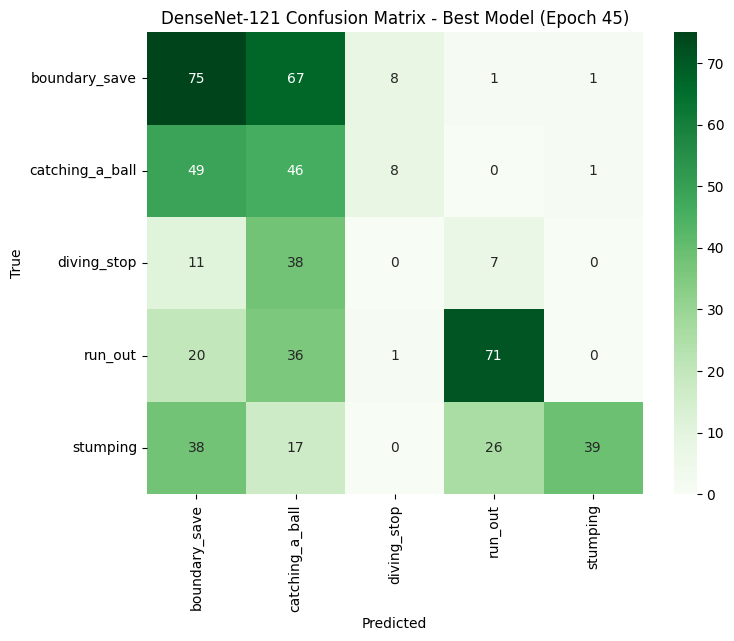

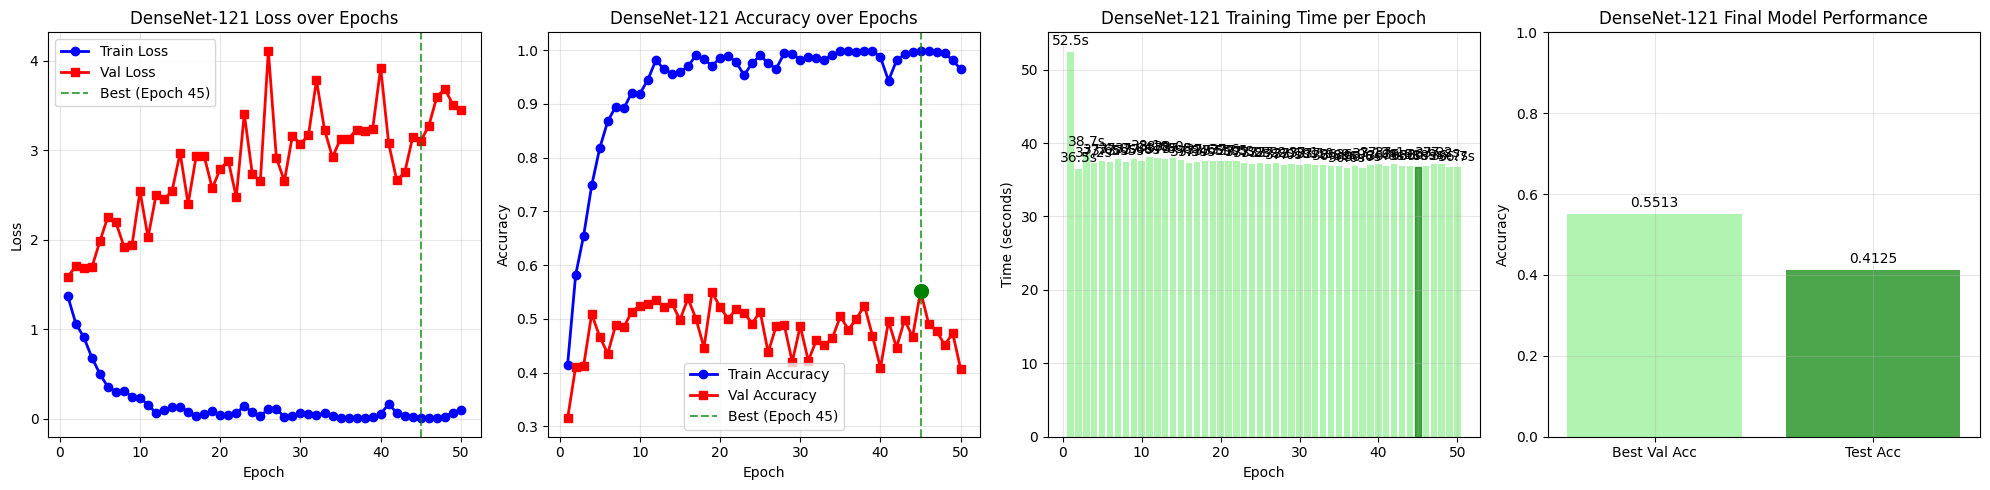


⏰ DenseNet-121 Final Timing Summary:
│ Total Training: 1878.14s
│ Average per Epoch: 37.56s
│ Testing Time: 9.94s
│ Total Runtime: 1888.08s

💾 DenseNet-121 Files saved:
│ best_densenet121_model.pth - Best validation accuracy model
│ densenet121_training_history.csv - Training metrics for later plotting


In [8]:
# -----------------------------
# 4. Training Loop with Best Model Saving (Val Accuracy) - DenseNet-121
# -----------------------------
import pandas as pd
from tqdm import tqdm
import time

train_losses, val_losses = [], []
train_accs, val_accs = [], []
epoch_times = []
epochs = 50

# Initialize best model tracking - CHANGED TO VAL_ACC
best_val_acc = 0.0  # Changed from best_val_loss = float('inf')
best_model_state = None
best_epoch = 0

print(f"\n🚀 Starting DenseNet-121 Training for {epochs} epochs...")
print("=" * 80)
total_start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    print(f"\n📈 Epoch {epoch+1}/{epochs}")
    print("-" * 50)
    
    # Training Phase
    print("🔄 Training Phase...")
    model.train()
    running_loss, correct, total = 0, 0, 0
    
    train_pbar = tqdm(train_loader, desc=f"Training", 
                     bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    train_phase_start = time.time()
    
    for batch_idx, (imgs, labels) in enumerate(train_pbar):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        current_acc = correct / total
        train_pbar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{current_acc:.4f}'
        })
        
        if device.type == 'cuda' and batch_idx % 10 == 0:
            gpu_memory = torch.cuda.memory_allocated() / 1024**3
            train_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}',
                'GPU': f'{gpu_memory:.1f}GB'
            })
    
    train_phase_time = time.time() - train_phase_start
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    print(f"✅ Training completed in {train_phase_time:.2f}s")
    
    # Validation Phase
    print("🔍 Validation Phase...")
    model.eval()
    running_loss, correct, total = 0, 0, 0
    
    val_phase_start = time.time()
    val_pbar = tqdm(val_loader, desc=f"Validation", 
                   bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(val_pbar):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            current_acc = correct / total
            val_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}'
            })
    
    val_phase_time = time.time() - val_phase_start
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"✅ Validation completed in {val_phase_time:.2f}s")
    
    # Check if this is the best model so far based on val_acc - CHANGED
    is_best = val_acc > best_val_acc  # Changed from val_loss < best_val_loss
    if is_best:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_model_state = model.state_dict().copy()
        print(f"🌟 New best DenseNet-121 model found! Validation Accuracy: {val_acc:.4f}")
    
    # Epoch Summary
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    
    print(f"\n📊 Epoch {epoch+1} Summary:")
    print(f"│ Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"│ Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"│ Train Time: {train_phase_time:.2f}s | Val Time: {val_phase_time:.2f}s")
    print(f"│ Total Epoch Time: {epoch_time:.2f}s")
    print(f"│ Best Val Acc: {best_val_acc:.4f} (Epoch {best_epoch})")  # Changed
    
    if device.type == 'cuda':
        print(f"│ GPU Memory: {torch.cuda.memory_allocated()/1024**3:.1f}GB / {torch.cuda.memory_reserved()/1024**3:.1f}GB")
    
    print("=" * 80)

total_training_time = time.time() - total_start_time

# Save the best model - UPDATED MESSAGES
if best_model_state is not None:
    torch.save(best_model_state, 'best_densenet121_model.pth')
    print(f"\n💾 Best DenseNet-121 model saved as 'best_densenet121_model.pth'")
    print(f"📊 Best model stats:")
    print(f"│ Best Epoch: {best_epoch}")
    print(f"│ Best Val Acc: {best_val_acc:.4f}")  # Changed from best_val_loss

# NEW: Save training history data to CSV
history_data = {
    'epoch': list(range(1, epochs+1)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs,
    'epoch_time': epoch_times
}
history_df = pd.DataFrame(history_data)
history_df.to_csv('densenet121_training_history.csv', index=False)
print("\n💾 DenseNet-121 training history saved to 'densenet121_training_history.csv'")

# Training Summary
print(f"\n🎉 DenseNet-121 Training Complete!")
print(f"Total Training Time: {total_training_time:.2f}s ({total_training_time/60:.1f} minutes)")
print(f"Average Epoch Time: {np.mean(epoch_times):.2f}s")
print("\n⏱️  Epoch Timing Breakdown:")
for i, t in enumerate(epoch_times):
    print(f"│ Epoch {i+1}: {t:.2f}s")

# -----------------------------
# 5. Load Best Model and Test
# -----------------------------
print(f"\n🧪 Loading Best DenseNet-121 Model for Testing...")
# Load the best model state
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"✅ Best DenseNet-121 model from epoch {best_epoch} loaded successfully!")
else:
    print("⚠️  No best model found, using current model state")

test_start_time = time.time()
y_true, y_pred = [], []
model.eval()

test_pbar = tqdm(test_loader, desc="Testing DenseNet-121", 
                bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')

with torch.no_grad():
    for imgs, labels in test_pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_time = time.time() - test_start_time
test_accuracy = accuracy_score(y_true, y_pred)

print(f"✅ DenseNet-121 Testing completed in {test_time:.2f}s")
print("\n📋 DenseNet-121 Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))
print(f"🎯 DenseNet-121 Test Accuracy: {test_accuracy:.4f}")

# Model Performance Summary - UPDATED
print(f"\n📊 DenseNet-121 Model Performance Summary:")
print(f"│ Best Validation Acc:  {best_val_acc:.4f} (Epoch {best_epoch})")  # Changed
print(f"│ Final Test Accuracy:  {test_accuracy:.4f}")
print(f"│ Val-Test Gap:         {abs(best_val_acc - test_accuracy):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"DenseNet-121 Confusion Matrix - Best Model (Epoch {best_epoch})")
plt.show()

# -----------------------------
# 6. Enhanced Visualizations - UPDATED
# -----------------------------
plt.figure(figsize=(20, 5))

# Loss Plot
plt.subplot(1, 4, 1)
plt.plot(range(1, epochs+1), train_losses, 'b-', label="Train Loss", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_losses, 'r-', label="Val Loss", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.legend()
plt.title("DenseNet-121 Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)

# Accuracy Plot - UPDATED
plt.subplot(1, 4, 2)
plt.plot(range(1, epochs+1), train_accs, 'b-', label="Train Accuracy", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_accs, 'r-', label="Val Accuracy", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_acc], color='green', s=100, zorder=5)  # Changed to best_val_acc
plt.legend()
plt.title("DenseNet-121 Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)

# Timing Plot
plt.subplot(1, 4, 3)
bars = plt.bar(range(1, epochs+1), epoch_times, color='lightgreen', alpha=0.7)
bars[best_epoch-1].set_color('green')
plt.title("DenseNet-121 Training Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.grid(True, alpha=0.3)
for i, t in enumerate(epoch_times):
    plt.text(i+1, t+0.5, f'{t:.1f}s', ha='center', va='bottom')

# Performance Comparison
plt.subplot(1, 4, 4)
metrics = ['Best Val Acc', 'Test Acc']
values = [best_val_acc, test_accuracy]
colors = ['lightgreen', 'green']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.title("DenseNet-121 Final Model Performance")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, 
             f'{val:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\n⏰ DenseNet-121 Final Timing Summary:")
print(f"│ Total Training: {total_training_time:.2f}s")
print(f"│ Average per Epoch: {np.mean(epoch_times):.2f}s")
print(f"│ Testing Time: {test_time:.2f}s")
print(f"│ Total Runtime: {total_training_time + test_time:.2f}s")

print(f"\n💾 DenseNet-121 Files saved:")
print(f"│ best_densenet121_model.pth - Best validation accuracy model")
print(f"│ densenet121_training_history.csv - Training metrics for later plotting")

In [9]:
import pandas as pd
df=pd.read_csv("/kaggle/working/densenet121_training_history.csv")
df

,epoch,train_loss,val_loss,train_acc,val_acc,epoch_time
0,1,1.369481,1.589239,0.414906,0.314732,52.464583
1,2,1.062492,1.701286,0.581573,0.410714,36.468312
2,3,0.909264,1.681728,0.654930,0.412946,38.670183
3,4,0.682717,1.692214,0.748239,0.508929,37.240293
4,5,0.500705,1.982442,0.817488,0.466518,37.610993
5,6,0.352769,2.259026,0.867371,0.435268,37.453887
6,7,0.302642,2.194200,0.894953,0.488839,37.796347
7,8,0.313434,1.923343,0.891432,0.484375,37.473644
8,9,0.243724,1.937409,0.920775,0.513393,37.777376
9,10,0.233796,2.543732,0.918427,0.524554,37.572481
